In [1]:
import pandas as pd, numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm_notebook as tqdm
# from help_functions import *

%matplotlib inline
sns.set_style('whitegrid')
mpl.rcParams['savefig.dpi'] = 300

# Helper Functions

In [11]:
def pd_tickround(df, tick_size=1):
    return np.round(df.astype(float).divide(tick_size)).multiply(tick_size).astype(int)

def tickround(x, tick_size=5):
    return int(tick_size * round(float(x)/tick_size))

def calc_n_ticks(side, inverse, target_price, tick_size, maker_fee, taker_fee):
    if side == 'long':
        if inverse:
            n_ticks = -target_price * (taker_fee - maker_fee) / (tick_size * (taker_fee - maker_fee - 1)) + 1
        else:
            n_ticks = target_price * (taker_fee - maker_fee) / tick_size + 1
    elif side == 'short':
        if inverse:
            n_ticks = (target_price/tick_size) * (1 / (maker_fee - taker_fee -1) + 1) + 1
        else:
            n_ticks = target_price * (taker_fee - maker_fee) / tick_size + 1
    return abs(n_ticks)

def calc_exec_price(side, inverse, target_price, tick_size, maker_fee, taker_fee, thresh=5):
    n_ticks = calc_n_ticks(side, inverse, target_price, tick_size, maker_fee, taker_fee)
    n_ticks = np.max([0, n_ticks-thresh])
    if side == 'long':
        exec_price = target_price + n_ticks * tick_size
    elif side == 'short':
        exec_price = target_price - n_ticks * tick_size
    return tickround(exec_price, tick_size)

# Load Data

In [2]:
settings_path = 'data/symbol_settings.csv'
symbol_settings = pd.read_csv(settings_path, index_col=0)
symbol_settings

,contract,target_price,multiplier,tick_size,inverse,initial_margin,maint_margin,maker_fee,taker_fee
symbol,,,,,,,,,
XBTUSD,XBTUSD,1029050,100.0,50,True,0.01,0.005,-0.00025,0.00075
XBT1,XBTU19,1035500,100.0,50,True,0.01,0.005,-0.00025,0.00075
ETHUSD,ETHUSD,18810,100.0,5,False,0.02,0.010,-0.00025,0.00075
ADAXBT,ADAU19,457,100000000.0,1,False,0.05,0.025,-0.00050,0.00250
BCHXBT,BCHU19,3034000,100000000.0,1000,False,0.05,0.025,-0.00050,0.00250
EOSXBT,EOSU19,34960,100000000.0,10,False,0.05,0.025,-0.00050,0.00250
ETHXBT,ETHU19,1814000,100000000.0,1000,False,0.05,0.025,-0.00050,0.00250
LTCXBT,LTCU19,732500,100000000.0,500,False,0.05,0.025,-0.00050,0.00250
TRXXBT,TRXU19,167,100000000.0,1,False,0.05,0.025,-0.00050,0.00250


# Bitmex-Specific Idiosyncracies

## Plot Break-Evens

The code in this section isn't the cleanest; you're gonna have to forgive me on that one

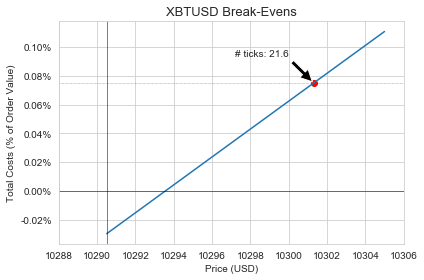

In [16]:
symbol = 'XBTUSD'

# Load symbol-specific parameters
ind = symbol_settings.loc[symbol]
side = 'long'
inverse = ind['inverse']
tick_size = ind['tick_size']
maker_fee = ind['maker_fee']
taker_fee = ind['taker_fee']
target_price = ind['target_price']

lo_ticks = 0
hi_ticks = 30
ticks = np.arange(-lo_ticks, hi_ticks)
prices = pd_tickround(pd.Series(target_price + ticks*tick_size, index=ticks))

# Calculate passive costs
if side == 'long':
    if inverse:
        limit_fees = 1 - target_price/(prices-tick_size) + maker_fee
    else:
        limit_fees = (prices-tick_size)/target_price - 1 + maker_fee
elif side == 'short':
    if inverse:
        limit_fees = maker_fee - (1 - target_price/(prices+tick_size))
    else:
        limit_fees = maker_fee - (prices+tick_size)/target_price + 1

n_ticks = calc_n_ticks(side=side, inverse=inverse, maker_fee=maker_fee, taker_fee=taker_fee, target_price=target_price, tick_size=tick_size)
break_even = target_price + n_ticks * tick_size

# Plot Break-Evens
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(prices, limit_fees)
ax.axvline(target_price, c='k', lw=0.5)
ax.axhline(0, c='k', lw=0.5)
ax.axhline(taker_fee, c='r', lw=0.5, linestyle=':')
ax.scatter(break_even, taker_fee, marker='o', color='r')
ax.annotate('# ticks: {:.3}'.format(n_ticks), xy=(break_even, taker_fee), 
            xytext=(break_even*0.9996, taker_fee*1.25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax.set_xticks(ax.get_xticks()[::1])
xvals = ax.get_xticks()
ax.set_xticklabels([int(x/100) for x in xvals])
yvals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in yvals])
ax.set_xlabel('Price (USD)')
ax.set_ylabel('Total Costs (% of Order Value)')
ax.set_title('XBTUSD Break-Evens', fontsize=13)

fig.tight_layout()
fig.savefig('XBTUSD Break-Evens')

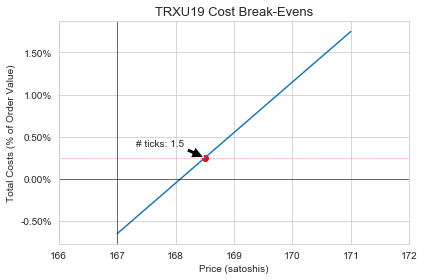

In [14]:
symbol = 'TRXXBT'

# Load symbol-specific parameters
ind = symbol_settings.loc[symbol]
side = 'long'
inverse = ind['inverse']
tick_size = ind['tick_size']
maker_fee = ind['maker_fee']
taker_fee = ind['taker_fee']
target_price = ind['target_price']

lo_ticks = 0
hi_ticks = 5
ticks = np.arange(-lo_ticks, hi_ticks)
prices = pd_tickround(pd.Series(target_price + ticks*tick_size, index=ticks))

# Calculate passive costs
if side == 'long':
    if inverse:
        limit_fees = 1 - target_price/(prices-tick_size) + maker_fee
    else:
        limit_fees = (prices-tick_size)/target_price - 1 + maker_fee
elif side == 'short':
    if inverse:
        limit_fees = maker_fee - (1 - target_price/(prices+tick_size))
    else:
        limit_fees = maker_fee - (prices+tick_size)/target_price + 1

n_ticks = calc_n_ticks(side=side, inverse=inverse, maker_fee=maker_fee, taker_fee=taker_fee, target_price=target_price, tick_size=tick_size)
break_even = target_price + n_ticks * tick_size

# Plot Break-Evens
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(prices, limit_fees)
ax.axvline(target_price, c='k', lw=0.5)
ax.axhline(0, c='k', lw=0.5)
ax.axhline(taker_fee, c='r', lw=0.5, linestyle=':')
ax.scatter(break_even, taker_fee, marker='o', color='r')
# ax.annotate('# ticks: {}'.format(n_ticks), xy=(2,1))

ax.annotate('# ticks: {:,.2}'.format(n_ticks), xy=(break_even, taker_fee), 
            xytext=(break_even*.993, taker_fee*1.55),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )


ax.set_xlim(166, 172)
ax.set_xticks(ax.get_xticks()[::1])
yvals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in yvals])
ax.set_xlabel('Price (satoshis)')
ax.set_ylabel('Total Costs (% of Order Value)')
ax.set_title('TRXU19 Cost Break-Evens', fontsize=13)

fig.tight_layout()
fig.savefig('TRXU19 Break-Evens')

## Calculate Break-Evens for all symbols

In [20]:
symbols = symbol_settings.index
t = tqdm(symbols, leave=True)

for side in ['long', 'short']:
    print(side)
    for symbol in t:
        t.set_description(symbol)
        t.refresh()

        ind = symbol_settings.loc[symbol] # individual settings
        inverse = ind['inverse']
        tick_size = ind['tick_size']
        maker_fee = ind['maker_fee']
        taker_fee = ind['taker_fee']
        target_price = ind['target_price']

        n_ticks = calc_n_ticks(side=side, inverse=inverse, maker_fee=maker_fee, taker_fee=taker_fee, target_price=target_price, tick_size=tick_size)
        exec_price = calc_exec_price(side=side, inverse=inverse, maker_fee=maker_fee, taker_fee=taker_fee, target_price=target_price, tick_size=tick_size)
        print(symbol, int(n_ticks), target_price, exec_price)

long
XBTUSD 21 1029050 1029900
XBT1 21 1035500 1036350
ETHUSD 4 18810 18810
ADAXBT 2 457 457
BCHXBT 10 3034000 3039000
EOSXBT 11 34960 35020
ETHXBT 6 1814000 1815000
LTCXBT 5 732500 732500
TRXXBT 1 167 167
XRPXBT 8 2541 2545
short
XBTUSD 21 1029050 1028200
XBT1 21 1035500 1034650
ETHUSD 4 18810 18810
ADAXBT 2 457 457
BCHXBT 10 3034000 3029000
EOSXBT 11 34960 34900
ETHXBT 6 1814000 1813000
LTCXBT 5 732500 732500
TRXXBT 1 167 167
XRPXBT 8 2541 2537


# Estimating Timing Risk

This is going to take a while.. go grab a cup of coffee

In [ ]:
n_trials = 50000
auto_correlations = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
results = pd.DataFrame(columns=auto_correlations, index=np.arange(n_trials))

for auto_correlation in tqdm(auto_correlations):
    
    for trial in range(n_trials):
    #     print('\n Trial #{}'.format(trial+1))

        # Reset the count
        down_ticks = 0
        up_ticks = 0
        total_excursion = 0 # tracks the total drift away from the start

        # Choose the first tick randomly
        tick = np.random.randint(0,2)

        while down_ticks < 2 and total_excursion < 25:
            # Set probability of next tick based on prev tick
            prob_up = auto_correlation if tick > 0 else (1 - auto_correlation)
            prob_down = 1 - prob_up
            tick = np.random.choice([0,1], p=[prob_down, prob_up])

    #         print('tick: {}1'.format('+' if tick>0 else '-'))
            # downtick
            if tick == 0:
                down_ticks += 1
                total_excursion -= 1
            elif tick == 1:
    #             up_ticks += 1
                down_ticks = 0 # reset the count; looking for 2 consecutive
                total_excursion += 1
            fill = total_excursion + 1
    #         print('Down Ticks: {}, Total Excursion: {}'.format(down_ticks, total_excursion))

    #     print('Fill: {}'.format(fill))
        results.loc[trial, auto_correlation] = fill
        

(-2, 5)

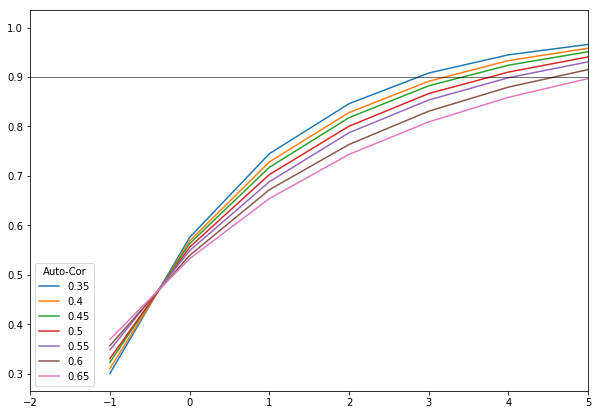

In [94]:
fig, ax = plt.subplots(figsize=(10,7))

for col in results.columns:
    (results[col].value_counts() / len(results)).sort_index().cumsum().plot(label=col, ax=ax)
plt.legend(title='Auto-Cor')
plt.axhline(0.9, c='k', lw=0.55)
# plt.xticks(np)
plt.xlim(-2, 5)